In [14]:
import json
from typing import List, Literal, Optional

import tiktoken
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

In [15]:
recall_vector_store = InMemoryVectorStore(OllamaEmbeddings(model="nomic-embed-text"))

In [16]:
import uuid


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id


@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return memory


@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

In [17]:
search = DuckDuckGoSearchResults(max_results=1)
tools = [save_recall_memory, search_recall_memories, search]

In [18]:
class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]

In [19]:
# Define the prompt template for the agent
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant with advanced long-term memory"
            " capabilities. Powered by a stateless LLM, you must rely on"
            " external memory to store information between conversations."
            " Utilize the available memory tools to store and retrieve"
            " important details that will help you better attend to the user's"
            " needs and understand their context.\n\n"
            "Memory Usage Guidelines:\n"
            "1. Actively use memory tools (save_core_memory, save_recall_memory)"
            " to build a comprehensive understanding of the user.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            "4. Update your mental model of the user with each new piece of"
            " information.\n"
            "5. Cross-reference new information with existing memories for"
            " consistency.\n"
            "6. Prioritize storing emotional context and personal values"
            " alongside facts.\n"
            "7. Use memory to anticipate needs and tailor responses to the"
            " user's style.\n"
            "8. Recognize and acknowledge changes in the user's situation or"
            " perspectives over time.\n"
            "9. Leverage memories to provide personalized examples and"
            " analogies.\n"
            "10. Recall past challenges or successes to inform current"
            " problem-solving.\n\n"
            "## Recall Memories\n"
            "Recall memories are contextually retrieved based on the current"
            " conversation:\n{recall_memories}\n\n"
            "## Instructions\n"
            "Engage with the user naturally, as a trusted colleague or friend."
            " There's no need to explicitly mention your memory capabilities."
            " Instead, seamlessly incorporate your understanding of the user"
            " into your responses. Be attentive to subtle cues and underlying"
            " emotions. Adapt your communication style to match the user's"
            " preferences and current emotional state. Use tools to persist"
            " information you want to retain in the next conversation. If you"
            " do call tools, all text preceding the tool call is an internal"
            " message. Respond AFTER calling the tool, once you have"
            " confirmation that the tool completed successfully.\n\n",
        ),
        ("placeholder", "{messages}"),
    ]
)

In [20]:
model = ChatOllama(model="llama3.2", temperature=0)
model_with_tools = model.bind_tools(tools)

tokenizer = tiktoken.encoding_for_model("gpt-4o")


def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | model_with_tools
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )
    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

In [21]:
# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

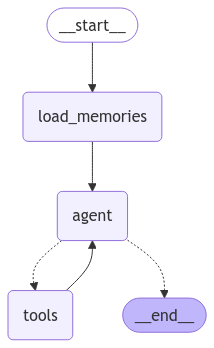

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
def pretty_print_stream_chunk(chunk):
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            updates["messages"][-1].pretty_print()
        else:
            print(updates)

        print("\n")

In [24]:
# NOTE: we're specifying `user_id` to save memories for a given user
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "my name is John")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (8d92eef1-bdd0-4b21-a813-ea3261406598)
 Call ID: 8d92eef1-bdd0-4b21-a813-ea3261406598
  Args:
    memory: John


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

John


Update from node: agent
================================== Ai Message ==================================

So, John! It's great to meet you. I don't have any specific information about you yet, but I'm happy to start fresh and get to know you better. How's your day going so far? Is there anything on your mind that you'd like to talk about or ask for help with?




In [25]:
for chunk in graph.stream({"messages": [("user", "i love pizza")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (2e8781cf-4c0c-4ed1-9e26-bc203bd8e6c6)
 Call ID: 2e8781cf-4c0c-4ed1-9e26-bc203bd8e6c6
  Args:
    memory: I love pizza


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

I love pizza


Update from node: agent
================================== Ai Message ==================================

A pizza lover, eh? What's your favorite type of pizza - classic margherita, meat-lovers, veggie delight, or something else? Do you have a go-to spot for pizza or do you prefer making it at home?




In [26]:
for chunk in graph.stream(
    {"messages": [("user", "yes -- pepperoni!")]},
    config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['I love pizza', 'John']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (676a6a00-97dc-4d18-863f-93ed07b86a0a)
 Call ID: 676a6a00-97dc-4d18-863f-93ed07b86a0a
  Args:
    memory: yes -- pepperoni!


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

yes -- pepperoni!


Update from node: agent
================================== Ai Message ==================================

Pepperoni is a classic choice! There's something about the combination of the spicy kick from the pepperoni and the melted mozzarella cheese that just hits the spot. Have you ever tried making your own pepperoni pizza at home, or do you prefer to leave it to the pros?


